# **Fused Decision LSTM-FFNN - feature set 3 dyanmic and static data**



We will combine our Fused Decision LSTM with FFNN to handle both time series and static data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.nn.utils.parametrizations as param
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import itertools
import json
import pickle

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Handling**

In [ ]:
class MultiInputTimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for time series data with multiple input sequences.

    Args:
        low_sequences (numpy.ndarray): Low-frequency sequences.
        medium_sequences (numpy.ndarray): Medium-frequency sequences.
        high_sequences (numpy.ndarray): High-frequency sequences.
        labels (numpy.ndarray): Corresponding labels for the sequences.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary containing the sequences and label for the given index.
    """
    def __init__(self, low_sequences, medium_sequences, high_sequences, static_features, labels):
        self.low_sequences = low_sequences
        self.medium_sequences = medium_sequences
        self.high_sequences = high_sequences
        self.static_features = static_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'low_freq_sequence': torch.tensor(self.low_sequences[idx], dtype=torch.float32),
            'medium_freq_sequence': torch.tensor(self.medium_sequences[idx], dtype=torch.float32),
            'high_freq_sequence': torch.tensor(self.high_sequences[idx], dtype=torch.float32),
            'static': torch.tensor(self.static_features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_multi_input_data_loaders(low_freq_train_sequences,
                                    medium_freq_train_sequences,
                                    high_freq_train_sequences,
                                    train_static,
                                    train_labels,
                                    low_freq_val_sequences,
                                    medium_freq_val_sequences,
                                    high_freq_val_sequences,
                                    val_static,
                                    val_labels,
                                    low_freq_test_sequences,
                                    medium_freq_test_sequences,
                                    high_freq_test_sequences,
                                    test_static,
                                    test_labels,
                                    batch_size):
    """
    Create data loaders for multi-input time series data.

    """
    train_dataset = MultiInputTimeSeriesDataset(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, train_labels)
    val_dataset = MultiInputTimeSeriesDataset(low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences, val_static, val_labels)
    test_dataset = MultiInputTimeSeriesDataset(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Data sampling**

In [ ]:
import numpy as np
from sklearn.utils import resample

def undersample_data(low_sequences, medium_sequences, high_sequences, static, labels):
    """
    Undersamples the data by randomly reducing the majority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.
        static (np.ndarray): Static features.
        labels (np.ndarray): Corresponding labels for sequences.

    Returns:
        tuple: Undersampled sequences and labels for low, medium, high frequency data, and static data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly undersample the majority class
    undersampled_majority_indices = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=42)

    # Combine minority and undersampled majority indices
    undersampled_indices = np.concatenate([minority_indices, undersampled_majority_indices])

    # Get the undersampled sequences, static, and labels
    low_sequences_resampled = low_sequences[undersampled_indices]
    medium_sequences_resampled = medium_sequences[undersampled_indices]
    high_sequences_resampled = high_sequences[undersampled_indices]
    static_resampled = static[undersampled_indices]
    labels_resampled = labels[undersampled_indices]

    return low_sequences_resampled, medium_sequences_resampled, high_sequences_resampled, static_resampled, labels_resampled

def oversample_data(low_sequences, medium_sequences, high_sequences, static, labels):
    """
    Oversamples the data by duplicating the minority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.
        static (np.ndarray): Static features.
        labels (np.ndarray): Corresponding labels for sequences.

    Returns:
        tuple: Oversampled sequences and labels for low, medium, high frequency data, and static data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly oversample the minority class
    oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=len(majority_indices), random_state=42)

    # Combine majority and oversampled minority indices
    oversampled_indices = np.concatenate([majority_indices, oversampled_minority_indices])

    # Get the oversampled sequences, static, and labels
    low_sequences_resampled = low_sequences[oversampled_indices]
    medium_sequences_resampled = medium_sequences[oversampled_indices]
    high_sequences_resampled = high_sequences[oversampled_indices]
    static_resampled = static[oversampled_indices]
    labels_resampled = labels[oversampled_indices]

    return low_sequences_resampled, medium_sequences_resampled, high_sequences_resampled, static_resampled, labels_resampled

**Early Stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.output_path)

### **Fused Decision LSTM-FFNN architecture**

We will combine the Fused LSTM model with FFNN to handle both static and dynamic data.

In [ ]:
class FusedLSTM_FFNN(nn.Module):
    """
    A fused LSTM model for sequence classification and handles masking.

    """
    def __init__(self, low_input_dim, medium_input_dim, high_input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, static_input_size, ffnn_layers, ffnn_units, ffnn_activation, ffnn_dropout):
      super(FusedLSTM_FFNN, self).__init__()
      self.hidden_dim = hidden_dim
      self.layer_dim = layer_dim

      if layer_dim == 1:
        dropout_prob = 0.0

      # LSTM for dynamic data
      self.low_lstm = nn.LSTM(low_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.medium_lstm = nn.LSTM(medium_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.high_lstm = nn.LSTM(high_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)


      # FFNN for static data
      ffnn_layers_list = []
      input_dim = static_input_size
      for _ in range(ffnn_layers):
        ffnn_layers_list.append(nn.Linear(input_dim, ffnn_units)) # Add linear layer
        if ffnn_activation == 'relu':
          ffnn_layers_list.append(nn.ReLU()) # Add ReLU activation function
        elif ffnn_activation == 'tanh':
          ffnn_layers_list.append(nn.Tanh()) # Add Tanh activation function
        elif ffnn_activation == 'sigmoid':
          ffnn_layers_list.append(nn.Sigmoid()) # Add Sigmoid activation function
        elif ffnn_activation == 'leaky_relu':
          ffnn_layers_list.append(nn.LeakyReLU()) # Add LeakyReLU activation function
        ffnn_layers_list.append(nn.Dropout(ffnn_dropout)) # Add dropout layer
        input_dim = ffnn_units # Update input dimension for next layer

      self.ffnn_network = nn.Sequential(*ffnn_layers_list)
      self.ffnn_output = nn.Linear(ffnn_units, hidden_dim)

      # Combined output
      self.combined_linear = nn.Linear(hidden_dim * 4, output_dim)

      # Define sigmoid for binary classification
      self.sigmoid = nn.Sigmoid()

      self.init_weights()

    # Function to initialize weights of the linear layer
    def init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
              nn.init.kaiming_normal_(m.weight)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)

    # Forward pass
    def forward(self, low_x, medium_x, high_x, static):
      # Create masks and handle NaNs
      low_mask = ~low_x.isnan()
      medium_mask = ~medium_x.isnan()
      high_mask = ~high_x.isnan()

      # Set NaNs to zeroes to be passed through model
      low_x = torch.where(low_mask, low_x, torch.zeros_like(low_x))
      medium_x = torch.where(medium_mask, medium_x, torch.zeros_like(medium_x))
      high_x = torch.where(high_mask, high_x, torch.zeros_like(high_x))

      # Initial hidden and cell states
      h0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)
      c0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)

      h0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)
      c0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)

      h0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)
      c0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)

      # Forward pass through LSTM layers
      low_out, _ = self.low_lstm(low_x, (h0_low, c0_low))
      medium_out, _ = self.medium_lstm(medium_x, (h0_medium, c0_medium))
      high_out, _ = self.high_lstm(high_x, (h0_high, c0_high))

      # Ensure masks are the same shape as the LSTM outputs
      low_mask = low_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, low_out.shape[-1])
      medium_mask = medium_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, medium_out.shape[-1])
      high_mask = high_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, high_out.shape[-1])

      # Apply masks to the LSTM outputs by zeroing out invalid positions
      low_out = low_out * low_mask.float()
      medium_out = medium_out * medium_mask.float()
      high_out = high_out * high_mask.float()

      # Get the last valid output for each sequence
      def get_last_valid_output(output, mask):
        last_valid_index = mask.sum(dim=1) - 1
        last_valid_index = torch.clamp(last_valid_index, min=0)  # Ensure no negative indices
        last_valid_index = last_valid_index.unsqueeze(1).unsqueeze(2).expand(-1, 1, output.size(-1))
        return output.gather(1, last_valid_index).squeeze(1)

      low_out_last = get_last_valid_output(low_out, low_mask[:, :, 0])
      medium_out_last = get_last_valid_output(medium_out, medium_mask[:, :, 0])
      high_out_last = get_last_valid_output(high_out, high_mask[:, :, 0])

      # Concatenate the LSTM outputs
      dynamic_out = torch.cat((low_out_last, medium_out_last, high_out_last), dim=1)

      # FFNN forward pass
      static_out = self.ffnn_network(static)
      static_out = self.ffnn_output(static_out)

      # Combine dynamic and static outputs
      out = torch.cat((dynamic_out, static_out), dim=1)

      # Apply the fully connected layer to fuse outputs
      out = self.combined_linear(out)

      # Apply sigmoid for binary classification
      out = self.sigmoid(out)

      return out

**Model training**

In [ ]:
def train_fused_model_with_early_stopping_logging(model, train_loader, val_loader,
                                                  criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the fused LSTM model with early stopping and logging.

    Parameters:
    model (nn.Module): The fused LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                low_freq_sequences = data['low_freq_sequence'].to(device)
                medium_freq_sequences = data['medium_freq_sequence'].to(device)
                high_freq_sequences = data['high_freq_sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)

                outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * low_freq_sequences.size(0)

                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

**Cross-validation**

In [ ]:
import numpy as np

def shuffle_data(low_sequences, medium_sequences, high_sequences, static_data, labels):
    assert len(low_sequences) == len(medium_sequences) == len(high_sequences) == len(static_data) == len(labels)
    p = np.random.permutation(len(labels))
    return low_sequences[p], medium_sequences[p], high_sequences[p], static_data[p], labels[p]

def split_data_into_folds(low_sequences, medium_sequences, high_sequences, static_data, labels, num_folds):
    fold_size = len(labels) // num_folds
    low_folds = []
    medium_folds = []
    high_folds = []
    static_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(labels)
        else:
            end_idx = start_idx + fold_size
        low_folds.append(low_sequences[start_idx:end_idx])
        medium_folds.append(medium_sequences[start_idx:end_idx])
        high_folds.append(high_sequences[start_idx:end_idx])
        static_folds.append(static_data[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return low_folds, medium_folds, high_folds, static_folds, labels_folds

In [ ]:
import torch.nn as nn

def reset_model(model):
    """
    Reset the parameters of the model to their initial values.

    Parameters:
    model (nn.Module): The model whose parameters need to be reset.
    """
    def reset_parameters(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    def reset_lstm_parameters(lstm_model):
        for name, param in lstm_model.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

    # Reset parameters for the main model
    reset_parameters(model)

    # Reset parameters for each LSTM in the FusedLSTMModel
    reset_lstm_parameters(model.low_lstm)
    reset_lstm_parameters(model.medium_lstm)
    reset_lstm_parameters(model.high_lstm)

    # Reset parameters for the FFNN layers
    for layer in model.ffnn_network.children():
        reset_parameters(layer)

    # Reset parameters for fully connected and sigmoid layers
    reset_parameters(model.ffnn_output)
    reset_parameters(model.combined_linear)
    reset_parameters(model.sigmoid)

In [ ]:
def fused_lstm_ffnn_manual_cross_validation(low_sequences, medium_sequences, high_sequences,
                                            static_data, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    low_sequences, medium_sequences, high_sequences, static_data, labels = shuffle_data(low_sequences, medium_sequences, high_sequences, static_data, labels)
    low_folds, medium_folds, high_folds, static_folds, labels_folds = split_data_into_folds(low_sequences, medium_sequences, high_sequences, static_data, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        val_low = low_folds[i]
        val_medium = medium_folds[i]
        val_high = high_folds[i]
        val_static = static_folds[i]
        val_labels = labels_folds[i]

        train_low = np.concatenate([low_folds[j] for j in range(num_folds) if j != i])
        train_medium = np.concatenate([medium_folds[j] for j in range(num_folds) if j != i])
        train_high = np.concatenate([high_folds[j] for j in range(num_folds) if j != i])
        train_static = np.concatenate([static_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        low_input_dim = train_low.shape[2]
        medium_input_dim = train_medium.shape[2]
        high_input_dim = train_high.shape[2]
        static_input_size = train_static.shape[1]

        for params in hyperparameters:
            if params['sampling_method'] == 'undersample':
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = undersample_data(
                    train_low, train_medium, train_high, train_static, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = oversample_data(
                    train_low, train_medium, train_high, train_static, train_labels)
            else:
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = train_low, train_medium, train_high, train_static, train_labels

            train_loader, val_loader, _ = create_multi_input_data_loaders(
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled,
                val_low, val_medium, val_high, val_static, val_labels,
                val_low, val_medium, val_high, val_static, val_labels,
                batch_size=params['batch_size']
            )

            # Model with new hyperparameters
            model = FusedLSTM_FFNN(
                low_input_dim=low_input_dim,
                medium_input_dim=medium_input_dim,
                high_input_dim=high_input_dim,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,  # Binary classification
                dropout_prob=params['dropout_prob'],
                static_input_size=static_input_size,
                ffnn_layers=params['ffnn_layers'],
                ffnn_units=params['ffnn_units'],
                ffnn_activation=params['ffnn_activation'],
                ffnn_dropout=params['ffnn_dropout']
            ).to(device)

            reset_model(model)

            criterion = nn.BCELoss()

            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            model, train_losses, val_losses, val_aucs = train_fused_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            val_outputs = []
            val_labels_list = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    low_freq_sequences = data['low_freq_sequence'].to(device)
                    medium_freq_sequences = data['medium_freq_sequence'].to(device)
                    high_freq_sequences = data['high_freq_sequence'].to(device)
                    static = data['static'].to(device)
                    labels = data['label'].to(device).view(-1, 1)
                    outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)
                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels_list.extend(labels.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels_list, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_val_aucs


**Bayesian Objective Function**

In [ ]:
def objective_wrapper(low_train_sequences, medium_train_sequences, high_train_sequences, static_train_data, train_labels, hyperparameter_grid):
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', hyperparameter_grid['hidden_dim'])
        layer_dim = trial.suggest_categorical('layer_dim', hyperparameter_grid['layer_dim'])
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_int('num_epochs', min(hyperparameter_grid['num_epochs']), max(hyperparameter_grid['num_epochs']), step=10)
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # FFNN specific hyperparameters
        ffnn_layers = trial.suggest_int('ffnn_layers', min(hyperparameter_grid['ffnn_layers']), max(hyperparameter_grid['ffnn_layers']))
        ffnn_units = trial.suggest_categorical('ffnn_units', hyperparameter_grid['ffnn_units'])
        ffnn_activation = trial.suggest_categorical('ffnn_activation', hyperparameter_grid['ffnn_activation'])
        ffnn_dropout = trial.suggest_categorical('ffnn_dropout', hyperparameter_grid['ffnn_dropout'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay,
            'ffnn_layers': ffnn_layers,
            'ffnn_units': ffnn_units,
            'ffnn_activation': ffnn_activation,
            'ffnn_dropout': ffnn_dropout,
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_val_aucs = fused_lstm_ffnn_manual_cross_validation(
            low_train_sequences,
            medium_train_sequences,
            high_train_sequences,
            static_train_data,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Train final model**

In [ ]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)  # Static data input
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Plot the training losses at the end of training
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

    return model, train_losses

**Evaluate model**

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate various evaluation metrics.

    Parameters:
    model (nn.Module): The trained model to evaluate.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to run the model on.

    Returns:
    tuple: A tuple containing accuracy, precision, recall, F1 score, ROC AUC, and specificity.
    """
    model.to(device)
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)  # Static data input
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return test_outputs

**Load the data**

In [ ]:
# Load the sequences and labels
low_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/low_frequency_train_sequences_v1.npy'
medium_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/medium_frequency_train_sequences_v1.npy'
high_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/high_frequency_train_sequences_v1.npy'
labels_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/train_labels_v1.npy'

low_freq_train_sequences = np.load(low_train_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_train_sequences = np.load(medium_train_seq_path, allow_pickle=True).astype(np.float32)
high_freq_train_sequences = np.load(high_train_seq_path, allow_pickle=True).astype(np.float32)
labels_train = np.load(labels_train_path, allow_pickle=True).astype(np.float32)

print("Low frequency sequences shape:", low_freq_train_sequences.shape)
print("Medium frequency sequences shape:", medium_freq_train_sequences.shape)
print("High frequency sequences shape:", high_freq_train_sequences.shape)
print("Labels shape:", labels_train.shape)

Low frequency sequences shape: (3760, 4, 18)
Medium frequency sequences shape: (3760, 7, 10)
High frequency sequences shape: (3760, 13, 6)
Labels shape: (3760,)


In [ ]:
# Load the test sequences
low_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/low_frequency_test_sequences_v1.npy'
medium_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/medium_frequency_test_sequences_v1.npy'
high_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/high_frequency_test_sequences_v1.npy'

# Load the test labels
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/test_labels_v1.npy'

low_freq_test_sequences = np.load(low_test_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_test_sequences = np.load(medium_test_seq_path, allow_pickle=True).astype(np.float32)
high_freq_test_sequences = np.load(high_test_seq_path, allow_pickle=True).astype(np.float32)

labels_test = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

print(f'Low frequency test sequences shape: {low_freq_test_sequences.shape}')
print(f'Medium frequency test sequences shape: {medium_freq_test_sequences.shape}')
print(f'High frequency test sequences shape: {high_freq_test_sequences.shape}')
print(f'Test labels shape: {labels_test.shape}')

Low frequency test sequences shape: (941, 4, 18)
Medium frequency test sequences shape: (941, 7, 10)
High frequency test sequences shape: (941, 13, 6)
Test labels shape: (941,)


The static data is the same across both feature set 2 and 3 as there were no additional features used in literature.

In [ ]:
# Load the static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/train_static.npy'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/test_static.npy'

# Load the static data
train_static = np.load(train_static_path, allow_pickle=True).astype(np.float32)
test_static = np.load(test_static_path, allow_pickle=True).astype(np.float32)

print(f'Train static shape: {train_static.shape}')
print(f'Test static shape: {test_static.shape}')

Train static shape: (3760, 15)
Test static shape: (941, 15)


In [ ]:
train_static

array([[1.00018840e+07, 3.07330817e-01, 2.50000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.45161280e-03],
       [1.00024280e+07, 1.00563906e-01, 1.04166664e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.29032256e-02],
       [1.00042350e+07, 8.90037596e-01, 7.91666687e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.79203500e+07, 3.93796980e-01, 4.79166657e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.22580640e-03],
       [1.79217000e+07, 7.88533807e-01, 1.45833328e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.22580640e-03],
       [1.79231460e+07, 4.58616436e-01, 4.16666657e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [ ]:
# Remove the first column data
train_static = train_static[:, 1:]
test_static = test_static[:, 1:]

train_static

array([[0.30733082, 0.25      , 0.33753806, ..., 0.        , 0.        ,
        0.00645161],
       [0.10056391, 0.10416666, 0.17538421, ..., 0.        , 0.        ,
        0.01290323],
       [0.8900376 , 0.7916667 , 0.59560055, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.39379698, 0.47916666, 0.3357386 , ..., 0.        , 0.        ,
        0.00322581],
       [0.7885338 , 0.14583333, 0.8719525 , ..., 0.        , 0.        ,
        0.00322581],
       [0.45861644, 0.41666666, 0.41387522, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
train_static.shape, test_static.shape

((3760, 14), (941, 14))

# **Experiment 1**

Hyperparameters are a mix between the original LSTM params and FFNN params

In [ ]:
# Define new hyperparameter grid
param_grid_exp_1 = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # To mimic LSTM
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2],
    'ffnn_layers': [1, 2, 3],
    'ffnn_units': [32, 64, 128, 256],
    'ffnn_activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu'],
    'ffnn_dropout': [0.0, 0.25, 0.5, 0.75] # To mimic LSTM range
}

Run Bayesian Optimisation for Hyperparameter tuning

In [ ]:
# Run Bayesian Optimisation
study_exp_1 = optuna.create_study(direction='minimize')
study_exp_1.optimize(objective_wrapper(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train, param_grid_exp_1), n_trials=100)

best_params = study_exp_1.best_params
print("Best hyperparameters:", best_params)

# Save the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/static_and_dynamic_data/best_models/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

best_score = study_exp_1.best_value
print("Best score:", best_score)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'hidden_dim': 128, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 40, 'sampling_method': 'oversample', 'loss': 'normal', 'weight_decay': 1e-05, 'ffnn_layers': 1, 'ffnn_units': 32, 'ffnn_activation': 'relu', 'ffnn_dropout': 0.0}

Best score: -0.689366935048317



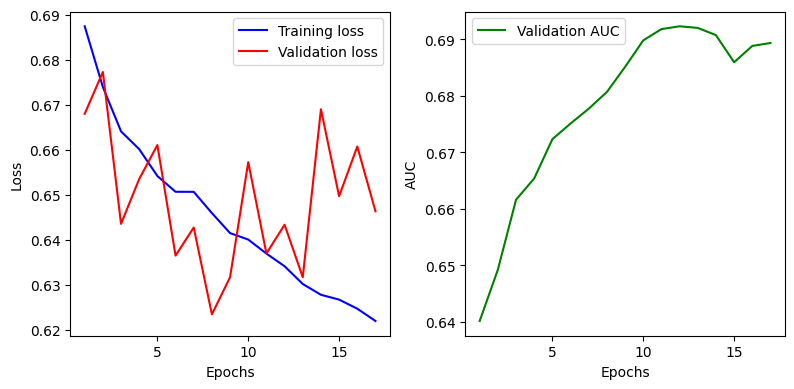

Model is slightly overfitting.

**Train the final model**

In [ ]:
best_params = {'hidden_dim': 128, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 40, 'sampling_method': 'oversample', 'loss': 'normal', 'weight_decay': 1e-05, 'ffnn_layers': 1, 'ffnn_units': 32, 'ffnn_activation': 'relu', 'ffnn_dropout': 0.0}

best_params

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.0,
 'learning_rate': 0.0001,
 'batch_size': 32,
 'num_epochs': 40,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 1e-05,
 'ffnn_layers': 1,
 'ffnn_units': 32,
 'ffnn_activation': 'relu',
 'ffnn_dropout': 0.0}

In [ ]:
# Define the final model
final_model = FusedLSTM_FFNN(
    low_input_dim=low_freq_train_sequences.shape[2],
    medium_input_dim=medium_freq_train_sequences.shape[2],
    high_input_dim=high_freq_train_sequences.shape[2],
    hidden_dim=best_params['hidden_dim'],
    layer_dim=best_params['layer_dim'],
    output_dim=1,
    dropout_prob=best_params['dropout_prob'],
    static_input_size=train_static.shape[1],
    ffnn_layers=best_params['ffnn_layers'],
    ffnn_units=best_params['ffnn_units'],
    ffnn_activation=best_params['ffnn_activation'],
    ffnn_dropout=best_params['ffnn_dropout']
)

final_model

FusedLSTM_FFNN(
  (low_lstm): LSTM(18, 128, num_layers=2, batch_first=True)
  (medium_lstm): LSTM(10, 128, num_layers=2, batch_first=True)
  (high_lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (ffnn_network): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
  )
  (ffnn_output): Linear(in_features=32, out_features=128, bias=True)
  (combined_linear): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'undersample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = undersample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
elif best_params['sampling_method'] == 'oversample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = oversample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
else:
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train

# Define the loss function
if best_params['loss'] == 'weighted':
  pos_weight = torch.tensor([best_params['pos_weight']]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimiser
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
final_model.to(device)

# Create data loaders
train_loader, _, test_loader = create_multi_input_data_loaders(
  train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled,
  _, _, _, _, _,
  low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
  batch_size=best_params['batch_size']
)

Epoch 1/40, Loss: 0.6910
Epoch 2/40, Loss: 0.6834
Epoch 3/40, Loss: 0.6732
Epoch 4/40, Loss: 0.6683
Epoch 5/40, Loss: 0.6645
Epoch 6/40, Loss: 0.6613
Epoch 7/40, Loss: 0.6600
Epoch 8/40, Loss: 0.6578
Epoch 9/40, Loss: 0.6561
Epoch 10/40, Loss: 0.6557
Epoch 11/40, Loss: 0.6546
Epoch 12/40, Loss: 0.6536
Epoch 13/40, Loss: 0.6509
Epoch 14/40, Loss: 0.6496
Epoch 15/40, Loss: 0.6503
Epoch 16/40, Loss: 0.6484
Epoch 17/40, Loss: 0.6465
Epoch 18/40, Loss: 0.6474
Epoch 19/40, Loss: 0.6465
Epoch 20/40, Loss: 0.6434
Epoch 21/40, Loss: 0.6430
Epoch 22/40, Loss: 0.6440
Epoch 23/40, Loss: 0.6408
Epoch 24/40, Loss: 0.6423
Epoch 25/40, Loss: 0.6392
Epoch 26/40, Loss: 0.6398
Epoch 27/40, Loss: 0.6375
Epoch 28/40, Loss: 0.6369
Epoch 29/40, Loss: 0.6373
Epoch 30/40, Loss: 0.6366
Epoch 31/40, Loss: 0.6356
Epoch 32/40, Loss: 0.6368
Epoch 33/40, Loss: 0.6355
Epoch 34/40, Loss: 0.6346
Epoch 35/40, Loss: 0.6335
Epoch 36/40, Loss: 0.6337
Epoch 37/40, Loss: 0.6333
Epoch 38/40, Loss: 0.6362
Epoch 39/40, Loss: 0.

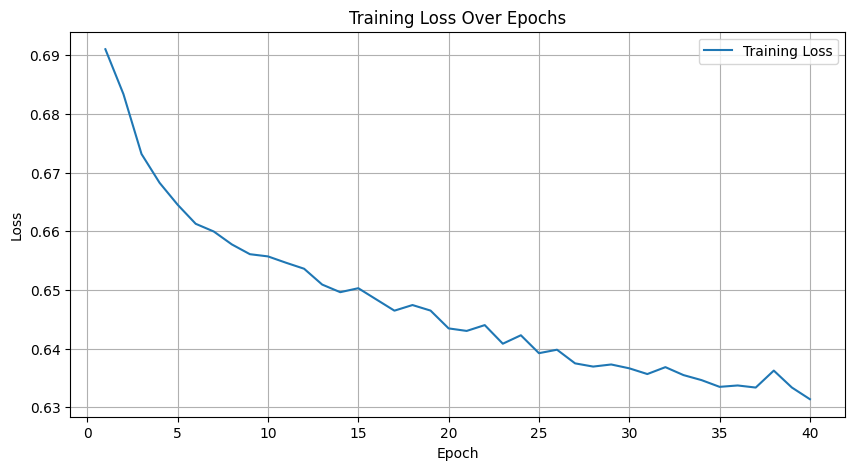

In [ ]:
# Train the final model
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device
)

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/static_and_dynamic_data/best_models/final_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)

**Evaluate the final model**

In [ ]:
# Evaluate the final model
evaluate_model(final_model, test_loader, device)

Accuracy: 0.6663
Precision: 0.4915
Recall (Sensitivity): 0.4660
F1 Score: 0.4784
ROC AUC: 0.6642
Specificity: 0.7642


(0.6663124335812965,
 0.49146757679180886,
 0.46601941747572817,
 0.4784053156146179,
 0.6642241202736472,
 0.7642405063291139)

In [ ]:
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/static_and_dynamic_data/best_models/final_model.pkl'
with open(model_path, 'rb') as file:
    final_model = pickle.load(file)

In [ ]:
predictions = evaluate_model(final_model, test_loader, device)

Accuracy: 0.6663
Precision: 0.4915
Recall (Sensitivity): 0.4660
F1 Score: 0.4784
ROC AUC: 0.6642
Specificity: 0.7642


In [ ]:
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/01_lstm_fused_decision/static_and_dynamic_data/best_models/predictions.npy', predictions)

**Calculate F1 mintority**

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

In [ ]:
calculate_f1_minority(final_model, test_loader, device)

0.4784053156146179

**Confusion matrix**

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_test_sequences = data['low_freq_sequence'].to(device)
            medium_freq_test_sequences = data['medium_freq_sequence'].to(device)
            high_freq_test_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, static_data)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['extubation_success', 'extubation_failure']  # Replace with your actual class names if different

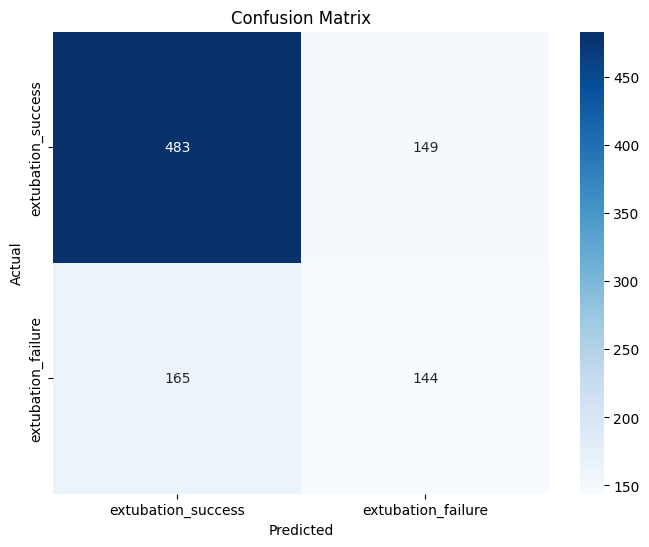

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

Heavily weighted on the extubation success side which is similar to TCN-FFNN.

**Plot ROC curve**

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_curve

def plot_roc_curve(model, test_loader, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc_score(all_labels, all_probs)))
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

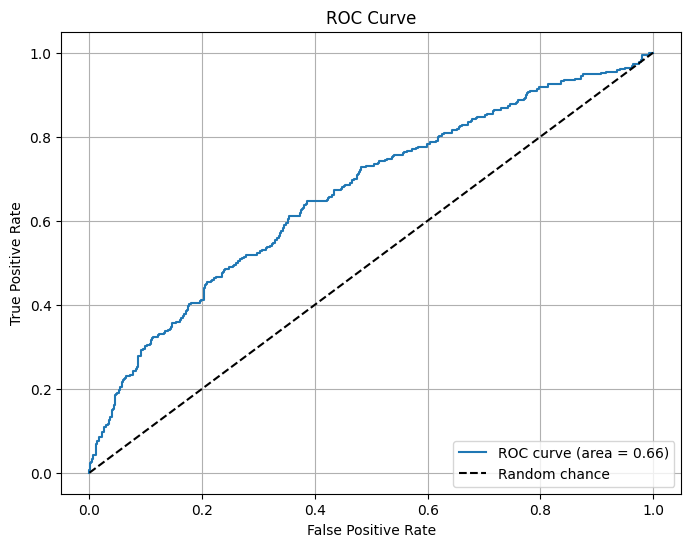

In [ ]:
plot_roc_curve(final_model, test_loader, device)

**Classification Threshold**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, test_loader, device):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = roc_auc_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
find_best_threshold_and_evaluate(final_model, test_loader, device)

Best Threshold: 0.45
Best Metric Value: 0.6278189136045225
Accuracy: 0.6334
Precision: 0.4565
Recall: 0.6117
F1 Score: 0.5228
ROC AUC: 0.6642
Specificity: 0.6440


{'best_threshold': 0.45,
 'best_metric_value': 0.6278189136045225,
 'accuracy': 0.6333687566418703,
 'precision': 0.45652173913043476,
 'recall': 0.6116504854368932,
 'f1_score': 0.5228215767634854,
 'roc_auc': 0.6642241202736472,
 'specificity': 0.6439873417721519}

### **Model Interpretability**

In [ ]:
# Load the feature names
low_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/low_freq_feature_names_v1.npy'
medium_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/medium_freq_feature_names_v1.npy'
high_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/01_lstm_data/dynamic_data_v2/high_freq_feature_names_v1.npy'

low_freq_feature_names = np.load(low_feature_names, allow_pickle=True)
medium_freq_feature_names = np.load(medium_feature_names, allow_pickle=True)
high_freq_feature_names = np.load(high_feature_names, allow_pickle=True)

print(low_freq_feature_names)
print(medium_freq_feature_names)
print(high_freq_feature_names)

['PH (Arterial)' 'Arterial O2 pressure' 'Arterial CO2 Pressure'
 'Arterial Base Excess' 'Sodium (serum)' 'Potassium (serum)'
 'Glucose (serum)' 'Creatinine (serum)' 'Hematocrit (serum)'
 'Cardiac Output (CCO)' 'Ionized Calcium' 'Hemoglobin' 'Platelet Count'
 'WBC' 'Arterial O2 Saturation' 'Lactic Acid' 'EtCO2' 'Plateau Pressure']
['Inspired O2 Fraction' 'GCS - Eye Opening' 'GCS - Motor Response'
 'Tidal Volume (observed)' 'Minute Volume' 'Mean Airway Pressure'
 'Peak Insp. Pressure' 'Temperature Fahrenheit'
 'Tidal Volume (spontaneous)' 'Richmond-RAS Scale']
['Heart Rate' 'O2 saturation pulseoxymetry' 'Respiratory Rate'
 'Arterial Blood Pressure mean' 'Arterial Blood Pressure diastolic'
 'Arterial Blood Pressure systolic']


In [ ]:
# Load static feature names
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/train_static.parquet'
train_df = pd.read_parquet(train_path)
static_feature_names = train_df.columns.tolist()

# Remove subject_id from the feature list
static_feature_names.remove('subject_id')

# Print the shape of the loaded feature names
print(f"Feature names shape: {len(static_feature_names)}")

Feature names shape: 14


**Feature ablation**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim

def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            low_sequences = data['low_freq_sequence'].to(device)
            medium_sequences = data['medium_freq_sequence'].to(device)
            high_sequences = data['high_freq_sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_sequences, medium_sequences, high_sequences, static)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * low_sequences.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

def train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_input_dim, medium_input_dim, high_input_dim, static_input_size, best_hyperparams, device):
    # Initialize a new model for this ablation
    ablation_model = FusedLSTM_FFNN(
        low_input_dim=low_input_dim,
        medium_input_dim=medium_input_dim,
        high_input_dim=high_input_dim,
        hidden_dim=best_hyperparams['hidden_dim'],
        layer_dim=best_hyperparams['layer_dim'],
        output_dim=1,
        dropout_prob=best_hyperparams['dropout_prob'],
        static_input_size=static_input_size,
        ffnn_layers=best_hyperparams['ffnn_layers'],
        ffnn_units=best_hyperparams['ffnn_units'],
        ffnn_activation=best_hyperparams['ffnn_activation'],
        ffnn_dropout=best_hyperparams['ffnn_dropout']
    ).to(device)

    optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

    # Train the model
    ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
        ablation_model, train_loader, val_loader, criterion, optimizer,
        best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
    )

    # Evaluate the model
    _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)
    return accuracy, precision, recall, f1, roc_auc, specificity

def feature_ablation_with_names(low_train_sequences, medium_train_sequences, high_train_sequences, train_static, train_labels,
                                low_test_sequences, medium_test_sequences, high_test_sequences, test_static, test_labels,
                                model, best_hyperparams, device, low_feature_names, medium_feature_names, high_feature_names, feature_names_static):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_static (np.array): The training static features.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_static (np.array): The test static features.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained TCN model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    low_feature_names (list): List of low frequency feature names.
    medium_feature_names (list): List of medium frequency feature names.
    high_feature_names (list): List of high frequency feature names.
    feature_names_static (list): List of static feature names.

    Returns:
    pd.DataFrame: DataFrame containing the feature importances.
    """
    feature_importances = defaultdict(dict)
    input_dim_static = train_static.shape[1]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(MultiInputTimeSeriesDataset(low_test_sequences, medium_test_sequences, high_test_sequences, test_static, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    # Ablation for low frequency features
    for feature_idx, feature_name in enumerate(low_feature_names):
        print(f"Ablating low frequency feature {feature_name} ({feature_idx + 1}/{len(low_feature_names)})")

        # Remove the feature from the sequences
        low_train_sequences_ablation = np.delete(low_train_sequences, feature_idx, axis=2)
        low_test_sequences_ablation = np.delete(low_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences_ablation, medium_train_sequences, high_train_sequences, train_static, train_labels,
            low_train_sequences_ablation, medium_train_sequences, high_train_sequences, train_static, train_labels,
            low_test_sequences_ablation, medium_test_sequences, high_test_sequences, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences_ablation.shape[2], medium_train_sequences.shape[2], high_train_sequences.shape[2], train_static.shape[1], best_hyperparams, device)

        feature_importances['low'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for medium frequency features
    for feature_idx, feature_name in enumerate(medium_feature_names):
        print(f"Ablating medium frequency feature {feature_name} ({feature_idx + 1}/{len(medium_feature_names)})")

        # Remove the feature from the sequences
        medium_train_sequences_ablation = np.delete(medium_train_sequences, feature_idx, axis=2)
        medium_test_sequences_ablation = np.delete(medium_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences_ablation, high_train_sequences, train_static, train_labels,
            low_train_sequences, medium_train_sequences_ablation, high_train_sequences, train_static, train_labels,
            low_test_sequences, medium_test_sequences_ablation, high_test_sequences, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences.shape[2], medium_train_sequences_ablation.shape[2], high_train_sequences.shape[2], train_static.shape[1], best_hyperparams, device)

        feature_importances['medium'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for high frequency features
    for feature_idx, feature_name in enumerate(high_feature_names):
        print(f"Ablating high frequency feature {feature_name} ({feature_idx + 1}/{len(high_feature_names)})")

        # Remove the feature from the sequences
        high_train_sequences_ablation = np.delete(high_train_sequences, feature_idx, axis=2)
        high_test_sequences_ablation = np.delete(high_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences, high_train_sequences_ablation, train_static, train_labels,
            low_train_sequences, medium_train_sequences, high_train_sequences_ablation, train_static, train_labels,
            low_test_sequences, medium_test_sequences, high_test_sequences_ablation, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences.shape[2], medium_train_sequences.shape[2], high_train_sequences_ablation.shape[2], train_static.shape[1], best_hyperparams, device)

        feature_importances['high'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for static features
    for feature_idx, feature_name in enumerate(feature_names_static):
        print(f"Ablating static feature {feature_name} ({feature_idx + 1}/{len(feature_names_static)})")

        # Remove the feature from the static data
        train_static_ablation = np.delete(train_static, feature_idx, axis=1)
        test_static_ablation = np.delete(test_static, feature_idx, axis=1)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences, high_train_sequences, train_static_ablation, train_labels,
            low_train_sequences, medium_train_sequences, high_train_sequences, train_static_ablation, train_labels,
            low_test_sequences, medium_test_sequences, high_test_sequences, test_static_ablation, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences.shape[2], medium_train_sequences.shape[2], high_train_sequences.shape[2], train_static_ablation.shape[1], best_hyperparams, device)

        feature_importances['static'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Combine feature importances for plotting
    combined_feature_importances = {**feature_importances['low'], **feature_importances['medium'], **feature_importances['high'], **feature_importances['static']}

    # Convert feature importances to DataFrames for better readability
    low_importances_df = pd.DataFrame.from_dict(feature_importances['low'], orient='index').sort_values(by='roc_auc', ascending=False)
    medium_importances_df = pd.DataFrame.from_dict(feature_importances['medium'], orient='index').sort_values(by='roc_auc', ascending=False)
    high_importances_df = pd.DataFrame.from_dict(feature_importances['high'], orient='index').sort_values(by='roc_auc', ascending=False)
    static_importances_df = pd.DataFrame.from_dict(feature_importances['static'], orient='index').sort_values(by='roc_auc', ascending=False)
    combined_importances_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index').sort_values(by='roc_auc', ascending=False)

    # Plot low frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(low_importances_df.index, low_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Low Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot medium frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(medium_importances_df.index, medium_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Medium Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot high frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(high_importances_df.index, high_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('High Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(static_importances_df.index, static_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot combined feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(combined_importances_df.index, combined_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Combined Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return combined_importances_df

Ablating low frequency feature PH (Arterial) (1/18)
Epoch 0/39, Loss: 0.6400, Val Loss: 0.6356, Val AUC: 0.5168
Epoch 1/39, Loss: 0.6335, Val Loss: 0.6282, Val AUC: 0.5624
Epoch 2/39, Loss: 0.6247, Val Loss: 0.6187, Val AUC: 0.6062
Epoch 3/39, Loss: 0.6168, Val Loss: 0.6135, Val AUC: 0.6192
Epoch 4/39, Loss: 0.6129, Val Loss: 0.6289, Val AUC: 0.6273
Epoch 5/39, Loss: 0.6139, Val Loss: 0.6105, Val AUC: 0.6282
Epoch 6/39, Loss: 0.6100, Val Loss: 0.6080, Val AUC: 0.6315
Epoch 7/39, Loss: 0.6103, Val Loss: 0.6059, Val AUC: 0.6335
Epoch 8/39, Loss: 0.6084, Val Loss: 0.6051, Val AUC: 0.6355
Epoch 9/39, Loss: 0.6068, Val Loss: 0.6088, Val AUC: 0.6402
Epoch 10/39, Loss: 0.6066, Val Loss: 0.6025, Val AUC: 0.6418
Epoch 11/39, Loss: 0.6043, Val Loss: 0.6018, Val AUC: 0.6433
Epoch 12/39, Loss: 0.6035, Val Loss: 0.6038, Val AUC: 0.6466
Epoch 13/39, Loss: 0.6043, Val Loss: 0.6000, Val AUC: 0.6461
Epoch 14/39, Loss: 0.6017, Val Loss: 0.6022, Val AUC: 0.6499
Epoch 15/39, Loss: 0.6014, Val Loss: 0.6001

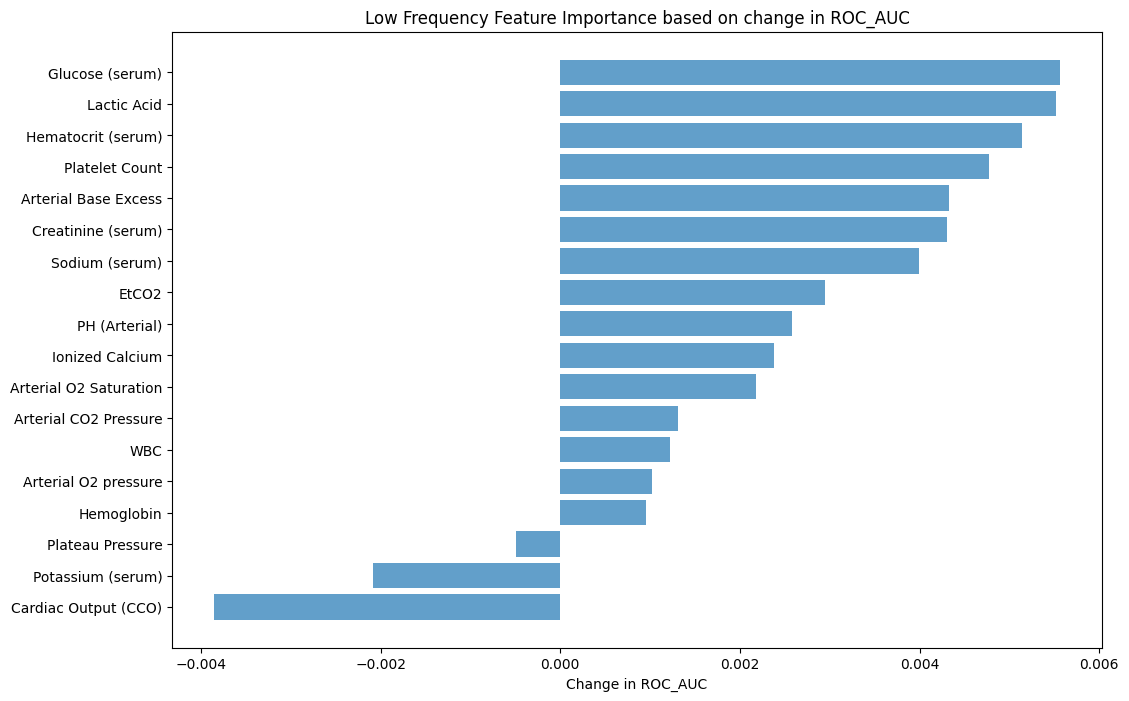

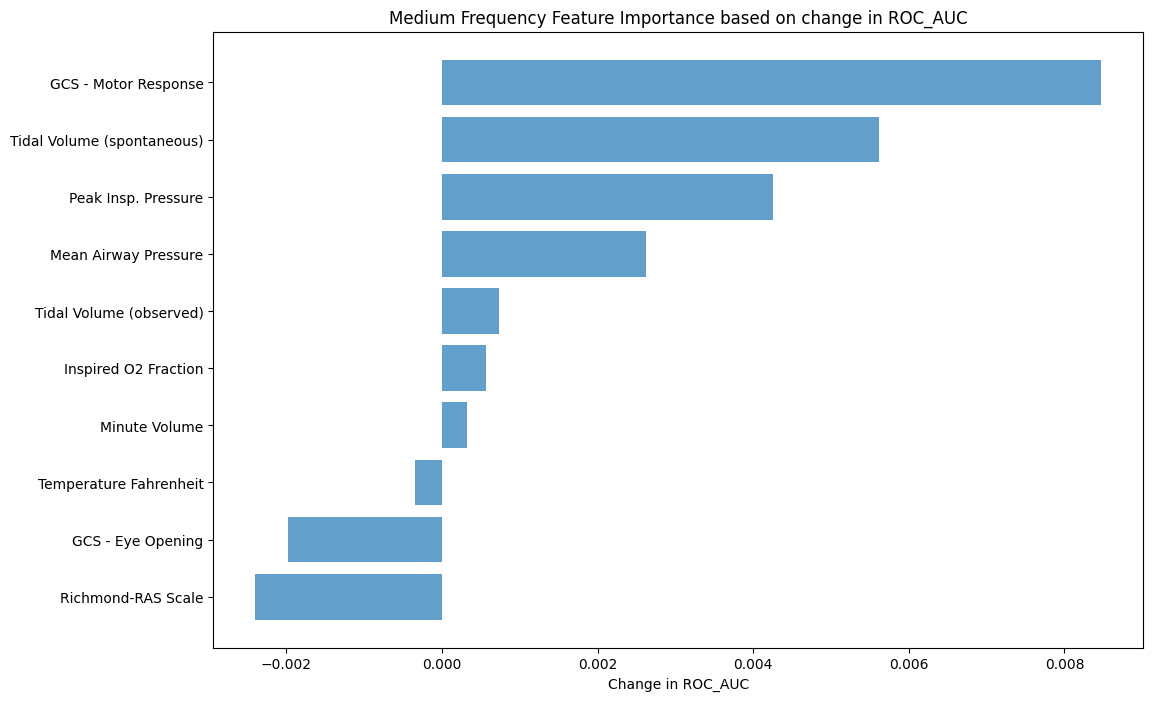

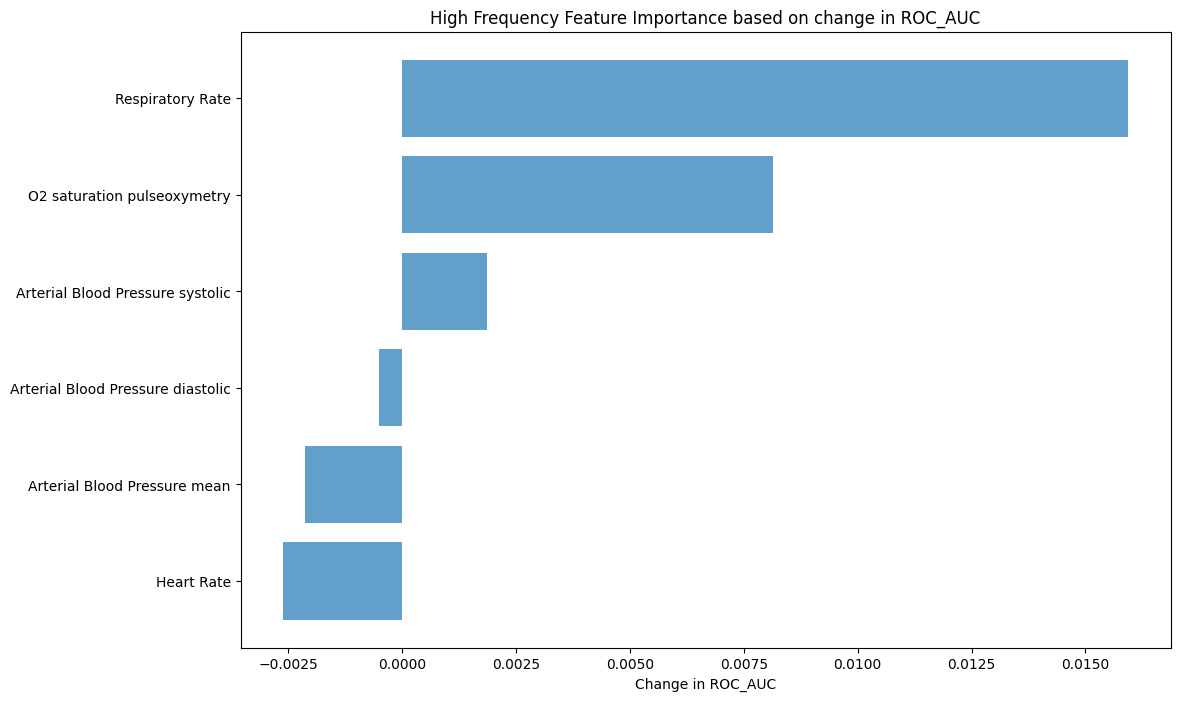

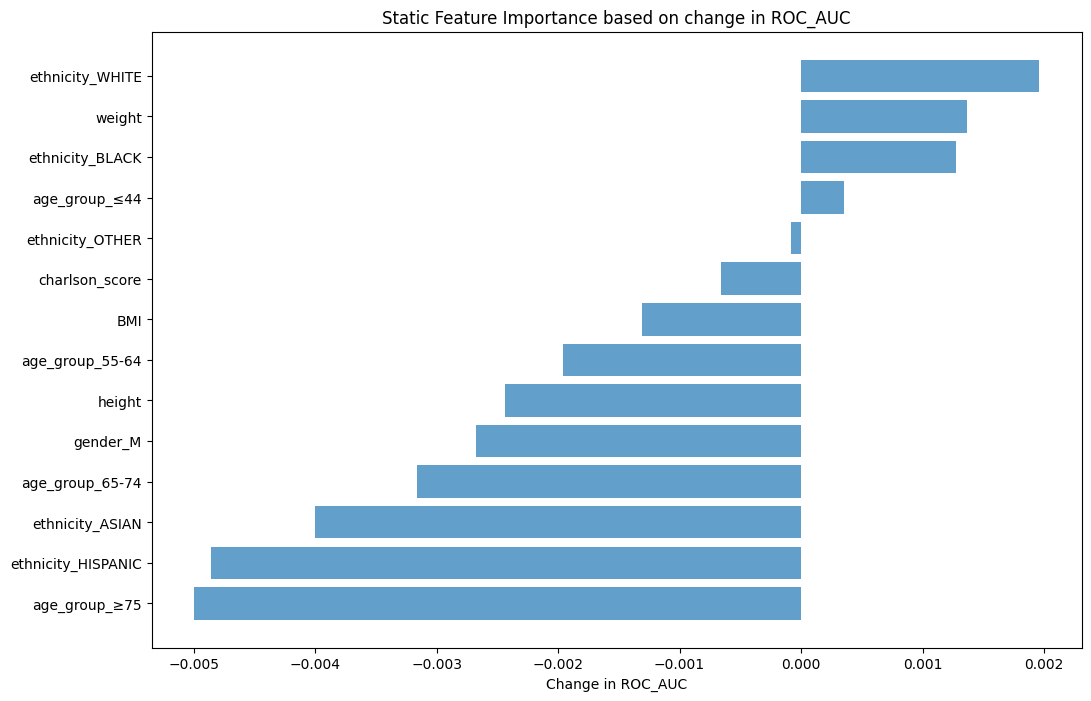

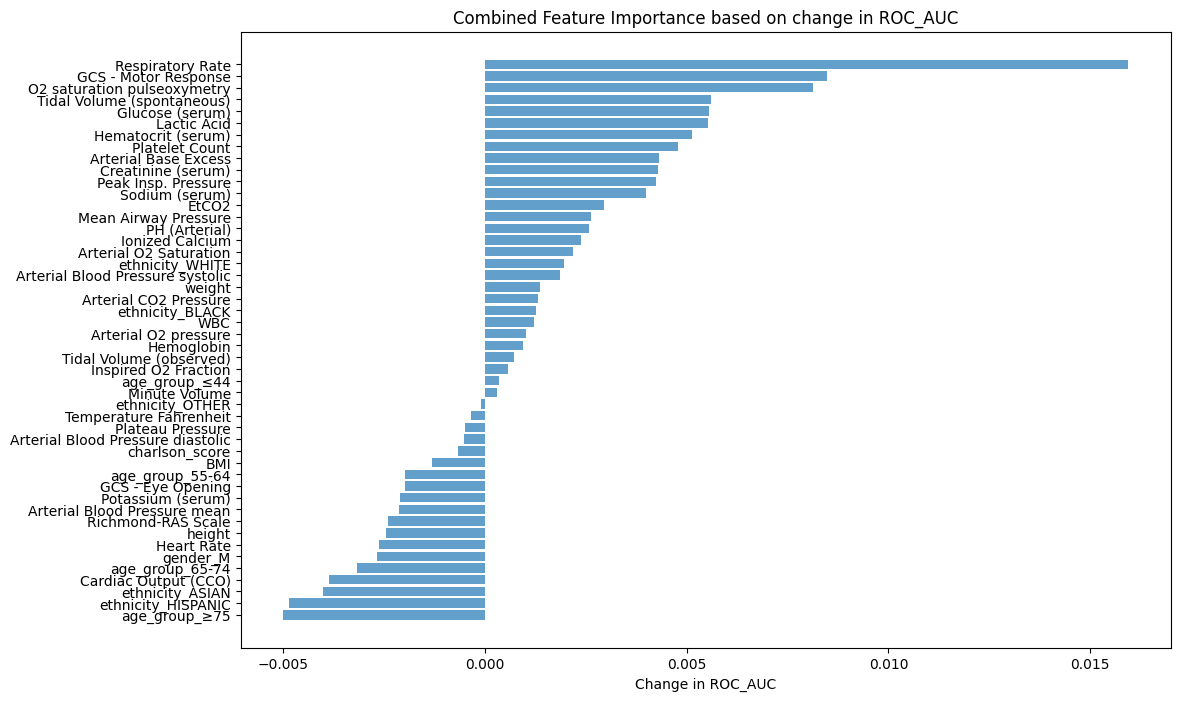

In [ ]:
# Run feature ablation
feature_importances = feature_ablation_with_names(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static,
                                                  labels_train, low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
                                                  final_model, best_params, device, low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names, static_feature_names)

In [ ]:
feature_importances

accuracy  precision    recall        f1  \
Respiratory Rate                  -0.019129  -0.131174  0.359223  0.296085   
GCS - Motor Response              -0.020191  -0.143148  0.359223  0.295580   
O2 saturation pulseoxymetry       -0.021254  -0.084290  0.281553  0.198994   
Tidal Volume (spontaneous)        -0.021254  -0.155591  0.359223  0.295072   
Glucose (serum)                   -0.028693  -0.105024  0.245955  0.156892   
Lactic Acid                       -0.025505  -0.099009  0.265372  0.178888   
Hematocrit (serum)                -0.021254  -0.101125  0.310680  0.232251   
Platelet Count                    -0.024442  -0.149157  0.333333  0.258566   
Arterial Base Excess              -0.019129  -0.115090  0.346278  0.278405   
Creatinine (serum)                -0.023379  -0.116127  0.310680  0.230983   
Peak Insp. Pressure               -0.028693  -0.170297  0.320388  0.239679   
Sodium (serum)                    -0.018066  -0.075199  0.300971  0.222766   
EtCO2                             -0.018066  -0.076714  0.304207  0.226516   
Mean Airway Pressure              -0.024442  -0.126953  0.313916  0.234249   
PH (Arterial)                     -0.025505  -0.115274  0.291262  0.207049   
Ionized Calcium                   -0.028693  -0.106747  0.249191  0.160116   
Arterial O2 Saturation            -0.024442  -0.095071  0.268608  0.183006   
ethnicity_WHITE                   -0.025505  -0.106471  0.278317  0.192691   
Arterial Blood Pressure systolic  -0.024442  -0.188532  0.355987  0.288990   
weight                            -0.013815  -0.064088  0.336570  0.268432   
Arterial CO2 Pressure             -0.022317  -0.091866  0.284790  0.201862   
ethnicity_BLACK                   -0.028693  -0.106747  0.249191  0.160116   
WBC                               -0.022317  -0.111097  0.313916  0.235511   
Arterial O2 pressure              -0.025505  -0.102592  0.271845  0.185722   
Hemoglobin                        -0.028693  -0.103360  0.242718  0.153699   
Tidal Volume (observed)           -0.025505  -0.108532  0.281553  0.196227   
Inspired O2 Fraction              -0.026567  -0.133532  0.304207  0.221336   
age_group_≤44                     -0.021254  -0.120473  0.333333  0.260320   
Minute Volume                     -0.031881  -0.093566  0.187702  0.101212   
ethnicity_OTHER                   -0.023379  -0.099930  0.288026  0.204773   
Temperature Fahrenheit            -0.035069  -0.179264  0.288026  0.197075   
Plateau Pressure                  -0.021254  -0.150042  0.355987  0.290560   
Arterial Blood Pressure diastolic -0.022317  -0.097421  0.294498  0.212741   
charlson_score                    -0.034006  -0.123917  0.233010  0.140377   
BMI                               -0.023379  -0.086514  0.262136  0.176970   
age_group_55-64                   -0.024442  -0.100369  0.278317  0.193393   
GCS - Eye Opening                 -0.027630  -0.089928  0.223301  0.135940   
Potassium (serum)                 -0.031881  -0.101125  0.207120  0.118045   
Arterial Blood Pressure mean      -0.025505  -0.112928  0.288026  0.203405   
Richmond-RAS Scale                -0.023379  -0.082445  0.252427  0.167085   
height                            -0.030818  -0.103771  0.223301  0.133578   
Heart Rate                        -0.028693  -0.106747  0.249191  0.160116   
gender_M                          -0.032944  -0.159695  0.284790  0.194861   
age_group_65-74                   -0.022317  -0.103771  0.304207  0.223952   
Cardiac Output (CCO)              -0.020191  -0.073347  0.268608  0.185839   
ethnicity_ASIAN                   -0.029756  -0.093718  0.210356  0.122549   
ethnicity_HISPANIC                -0.037194  -0.123917  0.207120  0.113941   
age_group_≥75                     -0.029756  -0.124694  0.268608  0.179386   

                                    roc_auc  specificity  
Respiratory Rate                   0.015941    -0.359223  
GCS - Motor Response               0.008470    -0.359223  
O2 saturation pulseoxymetry        

In [ ]:
feature_importances['feature'] = feature_importances.index

In [ ]:
# Combine all dynamic feature names
all_dynamic_feature_names = np.concatenate((low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names))
all_dynamic_feature_names = all_dynamic_feature_names.tolist()
feature_importances['feature'] = feature_importances.index

In [ ]:
def plot_feature_importances(dynamic_feature_names, static_feature_names, ablation_df):
    """
    Plots the feature importances for dynamic and static features based on ROC AUC change.

    Parameters:
    dynamic_feature_names (list): List of dynamic feature names.
    static_feature_names (list): List of static feature names.
    ablation_df (pd.DataFrame): DataFrame containing the feature importances with a 'feature' column and a 'roc_auc' column.
    """
    # Filter dynamic and static features
    dynamic_features_df = ablation_df[ablation_df['feature'].isin(dynamic_feature_names)]
    static_features_df = ablation_df[ablation_df['feature'].isin(static_feature_names)]

    # Plot dynamic features
    plt.figure(figsize=(12, 8))
    plt.barh(dynamic_features_df['feature'], dynamic_features_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Dynamic Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static features
    plt.figure(figsize=(12, 8))
    plt.barh(static_features_df['feature'], static_features_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

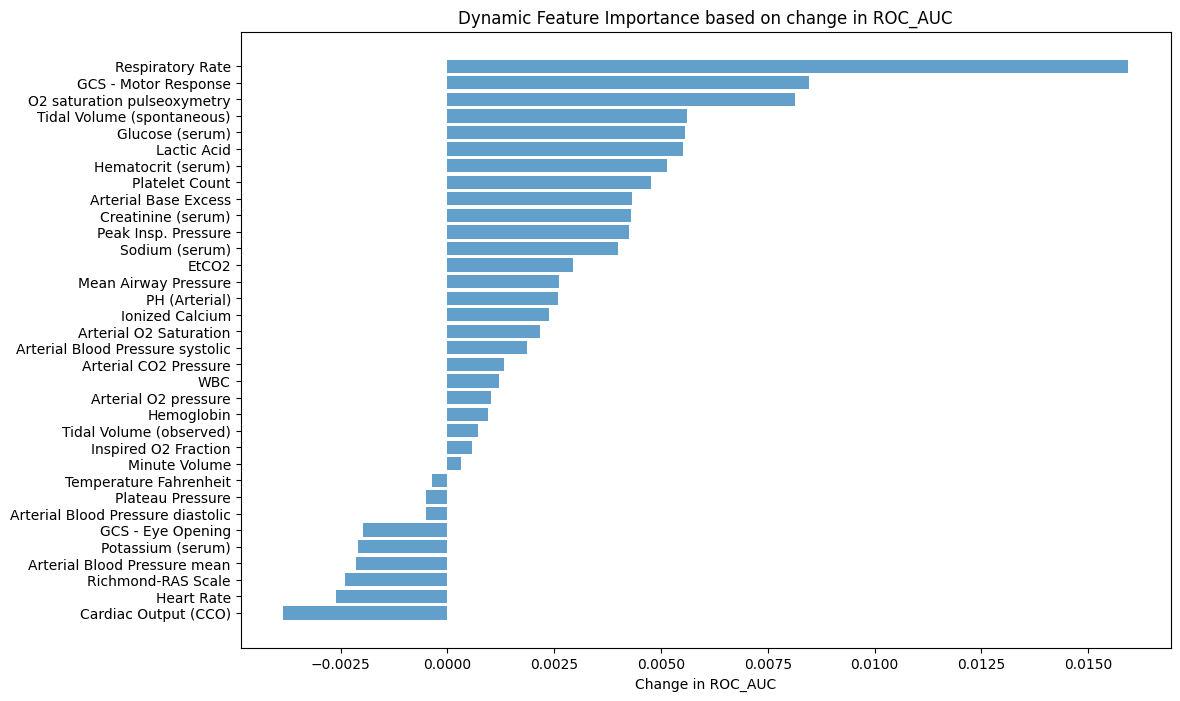

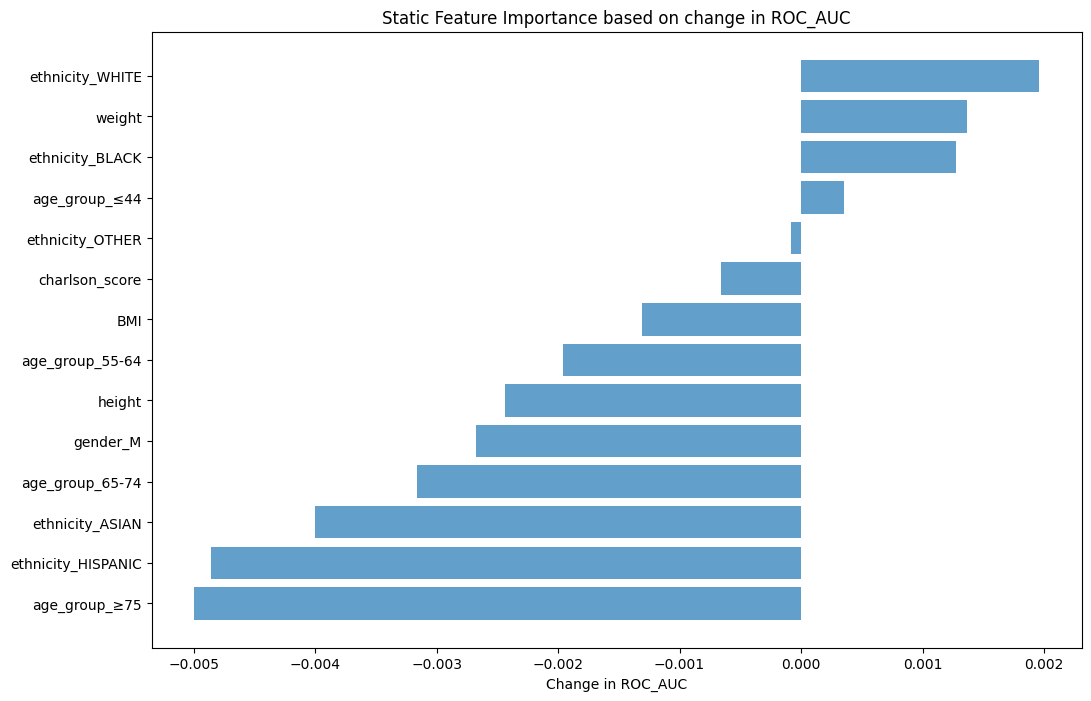

In [ ]:
plot_feature_importances(all_dynamic_feature_names, static_feature_names, feature_importances)